# BMS vs DMS Overlapped Gene Variants Analysis

In [159]:
# imports
import os
import sys
import glob
import operator
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from functools import reduce
from adjustText import adjust_text
from scipy.stats import spearmanr
import polars as pl
from Bio.PDB import PDBParser
# from sklearn.cluster import AgglomerativeClustering

sns.set_style(style='white')
sys.path.append("../../..")
from utils import *
clinvar_color_map = palette_dict["clinvar_clnsig_clean"]

# METADATA_INPUT = "../../../../1_allele_collection/1_inputs"
FEAT_SETS = ["GFP", "DNA", "Mito", "AGP", "Morph"]
# # Original cell imaging profiles
CLASS_RES_OUTDIR = "../../3_outputs/1_snakemake_pipeline/3.smp_results_analyses"
BIO_REP_BATCHES_DICT = {
    "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

# INTEGRATIVE_INPUT = "../../../../3_integrated_assay_analyses/1_inputs/imaging"
# GFP_MISLOCAL_FEAT_LENIENT = "Altered_95th_perc_both_batches_GFP"
# BATCH_LIST_DICT = {
#     # "2024_01_23_Batch_7": "2024_02_Batch_7-8", 
#     # "2024_02_06_Batch_8": "2024_02_Batch_7-8",
#     # "2024_12_09_Batch_11": "2024_12_Batch_11-12", 
#     # "2024_12_09_Batch_12": "2024_12_Batch_11-12",
#     "2025_01_27_Batch_13": "2025_01_Batch_13-14", 
#     "2025_01_28_Batch_14": "2025_01_Batch_13-14",
#     # "2025_03_17_Batch_15": "2025_03_Batch_15-16", 
#     # "2025_03_17_Batch_16": "2025_03_Batch_15-16"
# }

## 1. Overlapped Variants Info

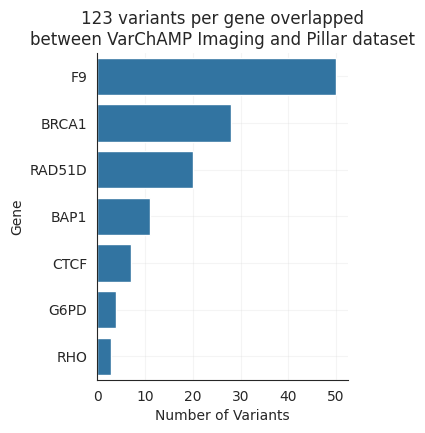

In [20]:
# pillar_clinvar_df = pl.read_csv(
#     "../../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_gold_standards_080425_processed.csv", 
#     infer_schema_length=1000000
# )
# pillar_clinvar_single_aa_df = pl.read_csv(
#     "../../../../1_allele_collection/1_inputs/raw_inputs/pillar_data/final_pillar_data_with_clinvar_gnomad_wREVEL_wAM_gold_standards_080425_snps_only.csv",
#     infer_schema_length=1000000
# )
imaging_summary_clinvar = pl.read_csv("../../3_outputs/2_results_summary/imaging_analyses_summary_clinvar.tsv", separator="\t", infer_schema_length=100000)
imaging_summary_clinvar_pillar_snp_match_df = imaging_summary_clinvar.with_columns(
    pl.col("nuc_loc").cast(pl.Int64).alias("nuc_loc")
).join(
    pillar_clinvar_single_aa_df,
    on=["Chrom", "nuc_loc", "ref_allele", "alt_allele"],
    suffix="_pp",
    how="inner"
)
imaging_summary_clinvar_pillar_snp_match_df.unique("gene_allele").shape

g = sns.catplot(data=imaging_summary_clinvar_pillar_snp_match_df.unique(subset="gene_variant").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
            x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)
g.ax.grid(alpha=.2)
plt.title(f"{imaging_summary_clinvar_pillar_snp_match_df.unique('gene_allele').shape[0]} variants per gene overlapped\nbetween VarChAMP Imaging and Pillar dataset")
plt.show()

In [21]:
## select key cols for output
imaging_summary_clinvar_pillar_snp_match_df_non_null = imaging_summary_clinvar_pillar_snp_match_df.select([
    col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
    if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
])

imaging_summary_clinvar_pillar_snp_match_df_non_null = imaging_summary_clinvar_pillar_snp_match_df.select(
    ["Gene","gene_allele","clinvar_clnsig_clean"]+\
    [f"AUROC_Mean_{feat}" for feat in FEAT_SETS]+\
    [f"Altered_95th_perc_both_batches_{feat}" for feat in FEAT_SETS]+\
    [c for c in imaging_summary_clinvar_pillar_snp_match_df.columns if "U2OS_" in c]+\
    [c for c in pillar_clinvar_single_aa_df.columns if c in imaging_summary_clinvar_pillar_snp_match_df.columns and c not in ["Gene","gene_allele"]]
)

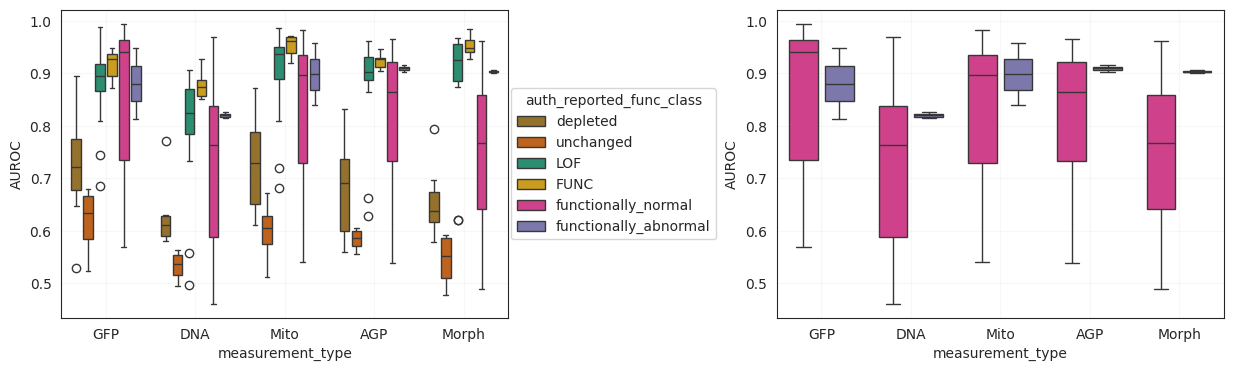

In [18]:
fig, axes = plt.subplots(1,2,figsize=(15,4))
color_palette = dict(zip(
    imaging_summary_clinvar_pillar_snp_match_df["auth_reported_func_class"].sort().unique(),
    sns.color_palette("Dark2")[:len(imaging_summary_clinvar_pillar_snp_match_df["auth_reported_func_class"].unique())]
))
sns.boxplot(
    data=imaging_summary_clinvar_pillar_snp_match_df.select([
        col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
        if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
    ]).unpivot(
       index=["auth_reported_func_class"],
       on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
       variable_name="measurement_type",
       value_name="AUROC"
    ).with_columns(
       pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
    ).to_pandas(),
    x="measurement_type",
    y="AUROC",
    hue="auth_reported_func_class",
    gap=.2,
    palette=color_palette,
    ax=axes[0],
    legend=True
)
axes[0].legend(loc="center right", bbox_to_anchor=(1.48,0.5), title="auth_reported_func_class")
sns.boxplot(
    data=imaging_summary_clinvar_pillar_snp_match_df.filter(
        pl.col("Dataset").str.contains("_unpublished")
    ).select([
        col for col in imaging_summary_clinvar_pillar_snp_match_df.columns 
        if imaging_summary_clinvar_pillar_snp_match_df.select(pl.col(col).is_null().all()).item() is False
    ]).unpivot(
       index=["auth_reported_func_class"],
       on=[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
       variable_name="measurement_type",
       value_name="AUROC"
    ).with_columns(
       pl.col("measurement_type").str.split("_").list.last().alias("measurement_type")
    ).to_pandas(),
    x="measurement_type",
    y="AUROC",
    hue="auth_reported_func_class",
    gap=.2,
    palette=color_palette,
    ax=axes[1],
    legend=False
)
for ax in axes:
    ax.grid(alpha=.15)
plt.subplots_adjust(wspace=.6)
plt.show()

In [89]:
## some files from the 1% manuscript github repo
# feat_df = pl.read_csv("/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/3_outputs/feat_importance_gt1e-3_all_alleles.csv")
sc_profile_feat_orig = pl.read_parquet(
    "/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_oneperc.parquet")
ref_var_cell_all_prof_df = pl.read_parquet(
    "/home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/ref_var_gfp_feat_sc_cp_profiles_oneperc_int_featselect.parquet"
)

batch_profile_dir = "../1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/batch_profiles"
sc_profile_feat_orig_b1314 = pl.concat([
    pl.read_parquet(f"{batch_profile_dir}/2025_01_27_Batch_13/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"),
    pl.read_parquet(f"{batch_profile_dir}/2025_01_28_Batch_14/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet")
], how="diagonal")

In [93]:
SM_CLASS_RES_DIR = "../1_snakemake_pipeline/2025_varchamp_snakemake/2.snakemake_pipeline/outputs/classification_results/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/"
FEAT = "GFP"

feat_import_df_feat = pl.DataFrame()
feat_df = pl.DataFrame()
## select all feat with importance > 1e-3
importance_thres = 1e-3
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    bio_rep_batches = BIO_REP_BATCHES_DICT[bio_rep]
    ## ONLY grep the allele come from the bio-rep
    allele_batch_df = imaging_summary_clinvar.filter(pl.col("Metadata_Bio_Batch")==bio_rep)
    batch_allele_list = list(allele_batch_df["gene_allele"]) + list(allele_batch_df["symbol"].unique())
    for batch_id in bio_rep_batches:
        # Read the data
        feat_df_b = pl.scan_csv(f"{SM_CLASS_RES_DIR.format(batch_id=batch_id)}/feat_importance.csv")
        meta_cols = [c for c in feat_df_b.collect_schema().names() if c.startswith("Metadata_") or c.startswith("Group") or c == "Batch"]
        feat_cols = [c for c in feat_df_b.collect_schema().names() if c not in meta_cols and FEAT in c]
        feat_df_batch = feat_df_b.with_columns(
            [pl.col(c).cast(pl.Float64, strict=False).alias(c) for c in feat_cols]
        ).with_columns(
            pl.lit(batch_id).alias("Metadata_Batch"),
            pl.col("Group2").str.split('_').list.slice(-2).list.join("_").alias("Metadata_gene_allele")
       ).filter(
            (pl.col("Metadata_Feature_Type")==FEAT)&(~pl.col("Metadata_Control"))
            &(pl.col("Group1").is_in(batch_allele_list)|(pl.col("Metadata_gene_allele").is_in(batch_allele_list)))
        ).select(meta_cols + feat_cols + ["Metadata_Batch", "Metadata_gene_allele"])
        feat_import_df_feat = pl.concat([feat_import_df_feat, feat_df_batch.collect()], how="diagonal")


for j, allele in tqdm(imaging_summary_clinvar.to_pandas().iterrows()):
    batch_list = list(feat_import_df_feat.filter(
        pl.col("Metadata_gene_allele")==allele["gene_allele"]
    ).unique("Metadata_Batch")["Metadata_Batch"])
    allele_df = pl.DataFrame()
    for i, batch in enumerate(batch_list):
        batch_df = feat_import_df_feat.filter(
            (pl.col("Metadata_Batch")==batch)&(pl.col("Metadata_gene_allele")==allele["gene_allele"])
        )
        feat_cols = [col for col in batch_df.columns if "Metadata" not in col and "Group" not in col]
        batch_df = batch_df.filter(
            ~pl.all_horizontal(pl.col(feat_cols).is_null())
        )
        non_null_gfp = [col for col in feat_cols if not batch_df[col].is_null().any()]
        batch_df_col = (
            batch_df.select(non_null_gfp).mean()
           .transpose(include_header=True)
           .filter(pl.col("column_0") > importance_thres)
           .sort("column_0", descending=True)
           # .head(top_num)#["column"]
           # .to_list()
        )
        if not allele_df.is_empty():
            allele_df = allele_df.join(
                batch_df_col.with_columns(
                    pl.col("column_0").alias(batch),
                    pl.col("column").alias("index"),
                ).select("index", batch),
                on="index",
                how="full",
                coalesce=True
            )
        else:
            allele_df = batch_df_col.with_columns(
                pl.col("column_0").alias(batch),
                pl.col("column").alias("index"),
            ).select("index", batch)
            
    allele_df = allele_df.with_columns(
        pl.mean_horizontal(pl.col([col for col in allele_df.columns if "Batch" in col])).alias("feat_importance"),
        pl.col("index").alias("cp_feature")
    ).select(
        pl.col(["cp_feature", "feat_importance"])
    ).rename(
        {"feat_importance": allele["gene_allele"]}
    )
    if not feat_df.is_empty():
        feat_df = feat_df.join(
            allele_df,
            left_on="cp_feature",
            right_on="cp_feature",
            how="full",
            coalesce=True
        )
    else:
        feat_df = allele_df

291it [00:41,  7.07it/s]


## 2. Gene by Gene Analyses

In [162]:
FEAT_SETS = FEAT_SETS[:-1]

### F9

<Figure size 640x480 with 0 Axes>

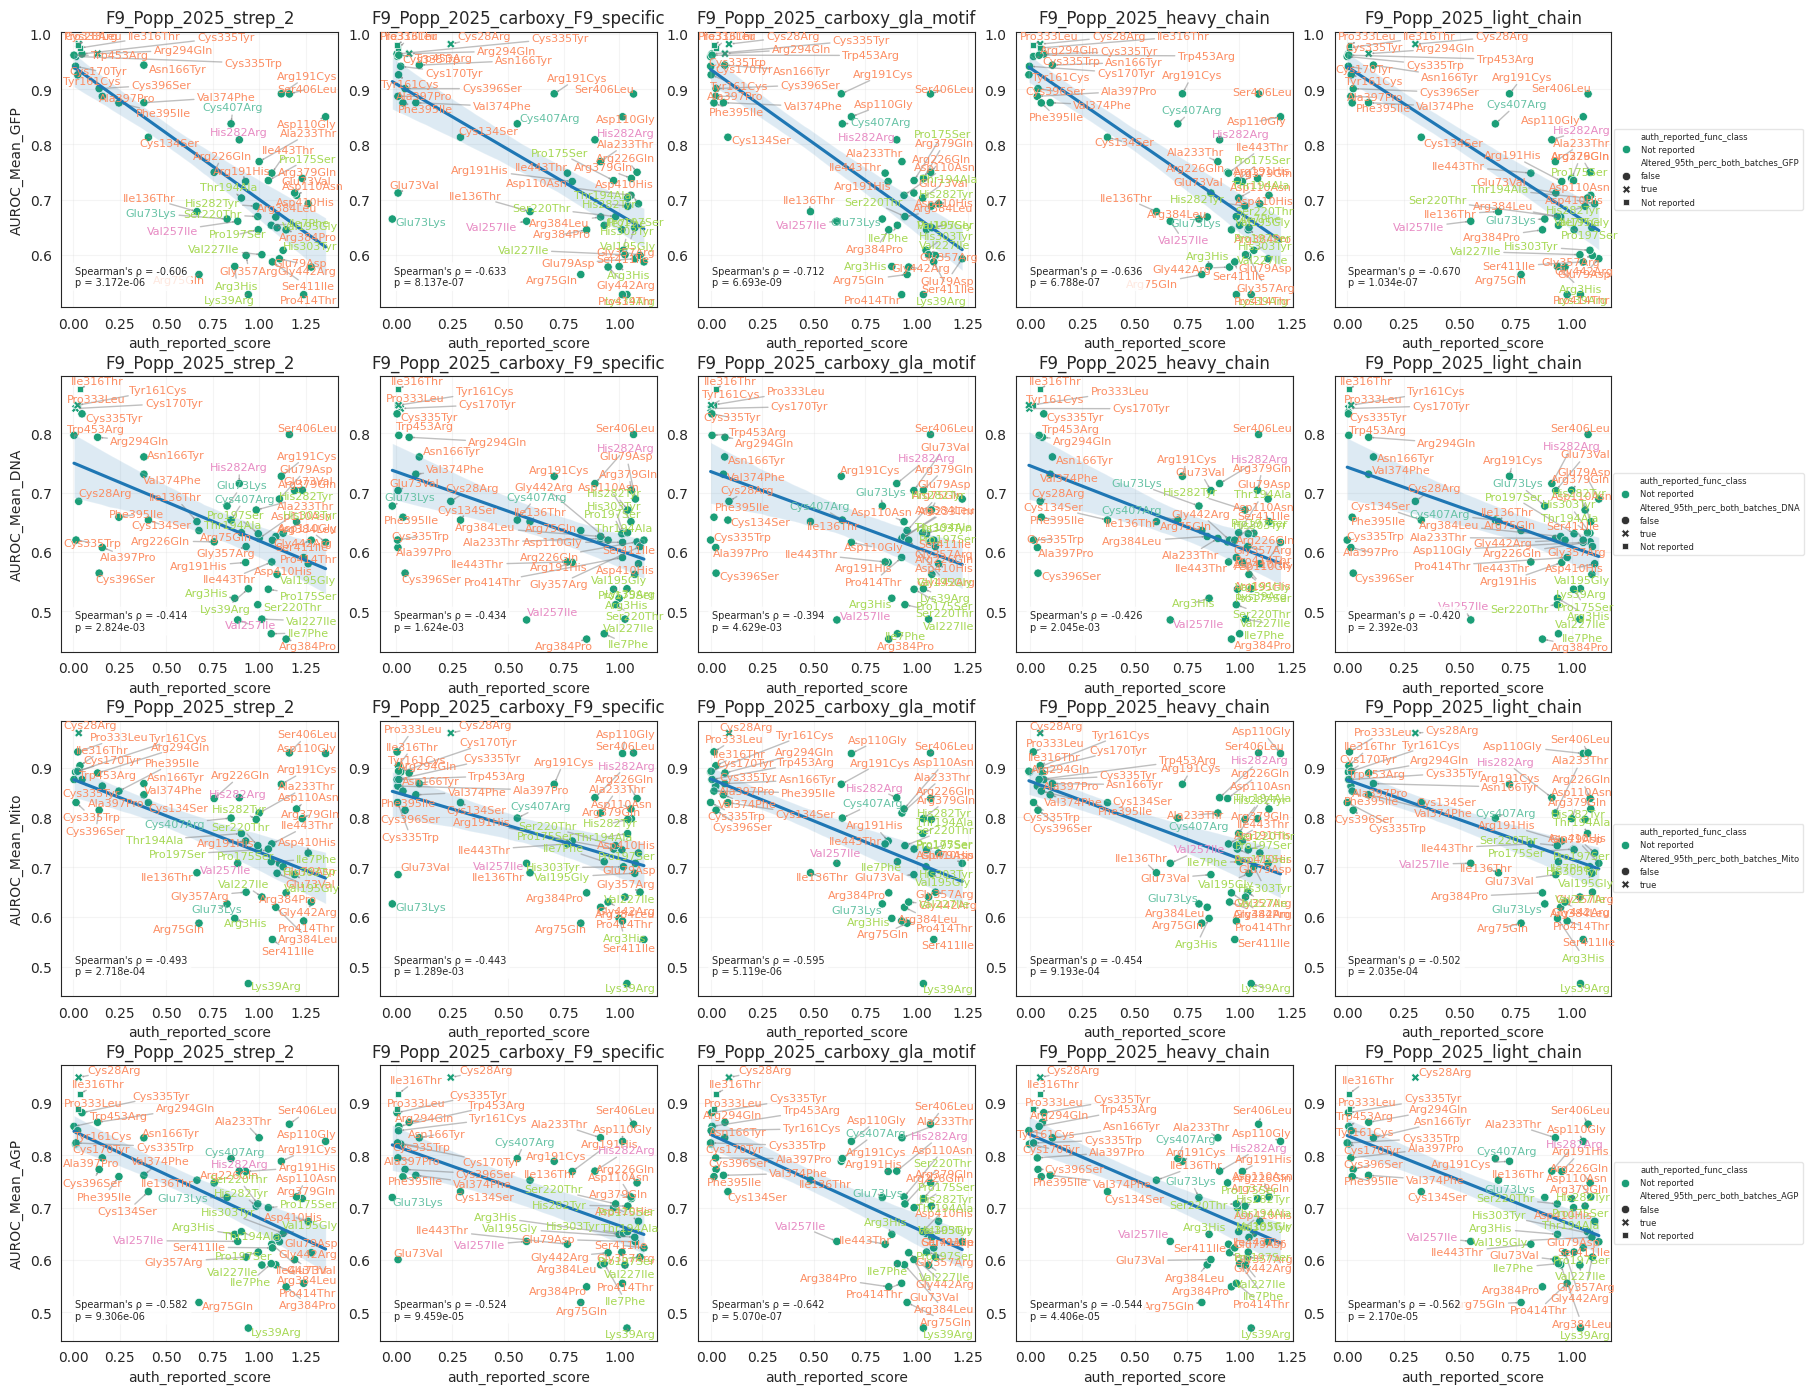

In [165]:
gene = "F9"
imaging_summary_clinvar_pillar_snp_match_df_gene = imaging_summary_clinvar_pillar_snp_match_df_non_null.filter(
    pl.col("Gene")==gene
)
studies_on_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["Dataset"].unique().to_list()
unique_variants_per_gene = imaging_summary_clinvar_pillar_snp_match_df_gene["gene_allele"].unique().to_list()

plt.clf()
fig, axes = plt.subplots(4, len(studies_on_gene), figsize=(20, 17)) ##sharey=True, 
for j, study in enumerate(studies_on_gene):
   imaging_summary_clinvar_pillar_snp_match_df_gene_study = imaging_summary_clinvar_pillar_snp_match_df_gene.filter(
       pl.col("Dataset")==study
   )
   imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull = imaging_summary_clinvar_pillar_snp_match_df_gene_study.with_columns(
       pl.col("auth_reported_score").cast(pl.Float64).alias("auth_reported_score")
   )
   for i, feat in enumerate(FEAT_SETS):
       sns.scatterplot(
           data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.with_columns(
               pl.col("auth_reported_func_class").fill_null("Not reported").alias("auth_reported_func_class"),
               pl.col(f"Altered_95th_perc_both_batches_{feat}").fill_null("Not reported").alias(f"Altered_95th_perc_both_batches_{feat}")
           ).to_pandas(),
           x="auth_reported_score",
           y=f"AUROC_Mean_{feat}",
           ax=axes[i, j],
           hue="auth_reported_func_class",
           style=f"Altered_95th_perc_both_batches_{feat}",
           palette="Dark2"
       )
       sns.regplot(
           data=imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas(),
           x="auth_reported_score",
           y=f"AUROC_Mean_{feat}",
           ax=axes[i, j],
           scatter=False
       )
       if j != len(studies_on_gene)-1:
           axes[i, j].get_legend().remove()
       else:
           axes[i, j].legend(bbox_to_anchor=(1.35, .5), 
                             loc="center",
                             fontsize=6, framealpha=.5, 
                             # bbox_transform=axes[i, -1].transAxes
           )
       # Get pandas dataframe for easier indexing
       plot_data = imaging_summary_clinvar_pillar_snp_match_df_gene_nonnull.to_pandas()
       # Add point labels with adjustText
       texts = []
       for idx, row in plot_data.iterrows():
           if not (np.isnan(row["auth_reported_score"]) or np.isnan(row[f"AUROC_Mean_{feat}"])):
               text = axes[i, j].annotate(
                   row["gene_allele"].split('_')[-1],
                   (row["auth_reported_score"], row[f"AUROC_Mean_{feat}"]),
                   fontsize=8,
                   color=clinvar_color_map[row["clinvar_clnsig_clean"]]
               )
               texts.append(text)
       adjust_text(texts, ax=axes[i, j], arrowprops=dict(arrowstyle='->', color='gray', alpha=0.5))
       # Calculate Spearman correlation
       mask = ~(np.isnan(plot_data["auth_reported_score"]) | np.isnan(plot_data[f"AUROC_Mean_{feat}"]))
       rho, p_val = spearmanr(
           plot_data["auth_reported_score"][mask], 
           plot_data[f"AUROC_Mean_{feat}"][mask]
       )
       
       # Add correlation text to plot
       axes[i, j].text(
           0.05, 0.15, 
           f'Spearman\'s ρ = {rho:.3f}\np = {p_val:.3e}',
           fontsize=7,
           transform=axes[i, j].transAxes,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
       )
       if j == 0:
           axes[i, j].set_ylabel(f"AUROC_Mean_{feat}")
       else:
           axes[i, j].set_ylabel("")
       axes[i, j].set_title(study)
       axes[i, j].grid(alpha=.2)
       
plt.subplots_adjust(wspace=0.15, hspace=0.25)
plt.show()

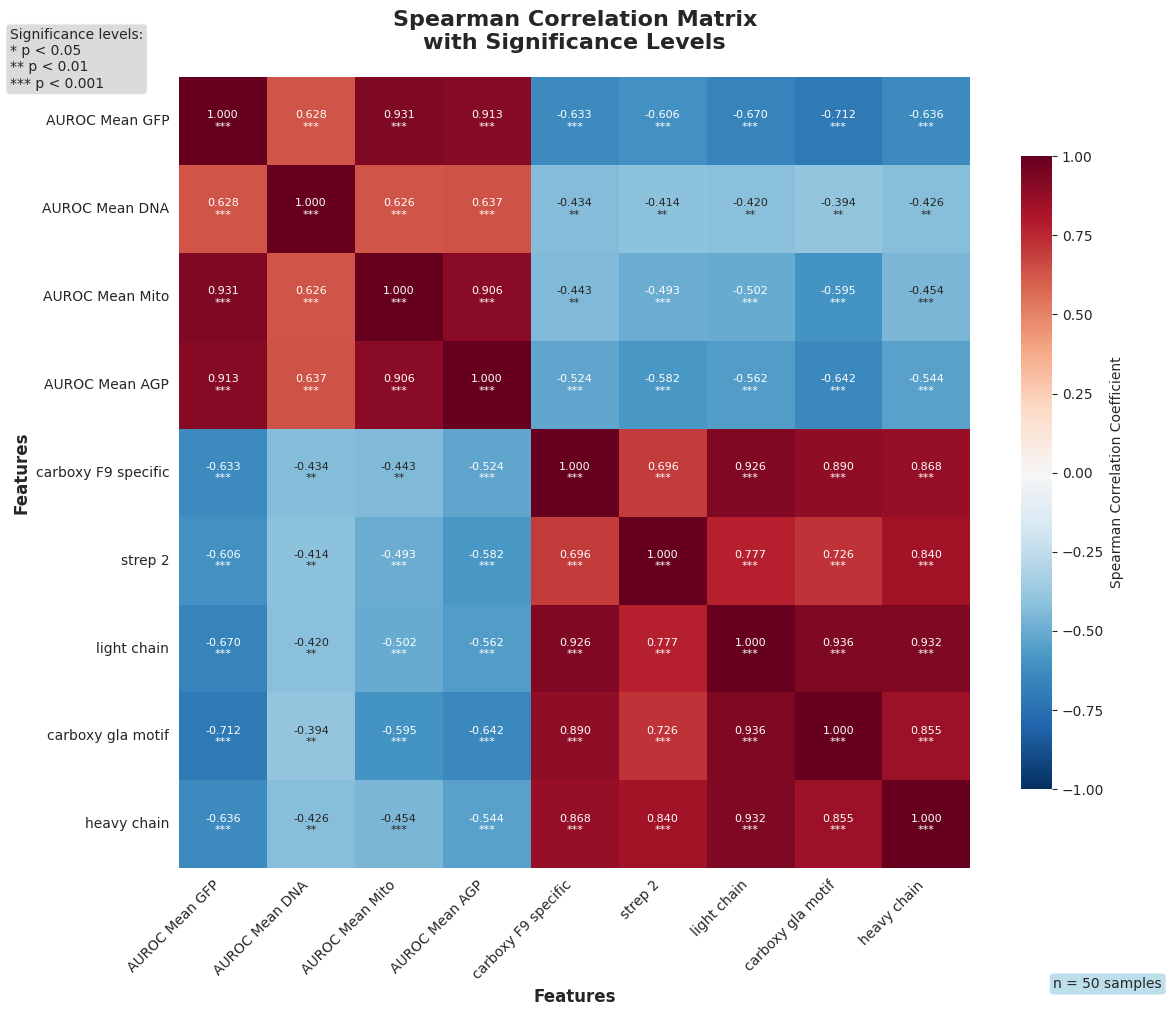

In [164]:
def create_spearman_heatmap(df, figsize=(12, 10)):
    """
    Create a Spearman correlation heatmap with significance annotations
    
    Parameters:
    df: polars DataFrame with numeric columns to correlate
    figsize: tuple for figure size
    """
    
    # Get numeric columns (exclude gene_allele or any string columns)
    numeric_columns = [col for col in df.columns if df[col].dtype in [pl.Float64, pl.Float32, pl.Int64, pl.Int32]]
    
    # Convert to pandas for easier correlation calculation
    df_numeric = df.select(numeric_columns).to_pandas()
    
    # Calculate Spearman correlation matrix and p-values
    n_vars = len(numeric_columns)
    corr_matrix = np.zeros((n_vars, n_vars))
    p_matrix = np.zeros((n_vars, n_vars))
    
    for i in range(n_vars):
        for j in range(n_vars):
            if i == j:
                corr_matrix[i, j] = 1.0
                p_matrix[i, j] = 0.0
            else:
                corr, p_val = spearmanr(df_numeric.iloc[:, i], df_numeric.iloc[:, j])
                corr_matrix[i, j] = corr
                p_matrix[i, j] = p_val
    
    # Create significance annotation matrix
    sig_matrix = np.zeros_like(p_matrix, dtype=object)
    for i in range(n_vars):
        for j in range(n_vars):
            if p_matrix[i, j] < 0.001:
                sig_matrix[i, j] = '***'
            elif p_matrix[i, j] < 0.01:
                sig_matrix[i, j] = '**'
            elif p_matrix[i, j] < 0.05:
                sig_matrix[i, j] = '*'
            else:
                sig_matrix[i, j] = ''
    
    # Create annotations combining correlation values and significance
    annot_matrix = np.zeros_like(corr_matrix, dtype=object)
    for i in range(n_vars):
        for j in range(n_vars):
            corr_val = f"{corr_matrix[i, j]:.3f}"
            sig_val = sig_matrix[i, j]
            annot_matrix[i, j] = f"{corr_val}\n{sig_val}" if sig_val else corr_val
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(corr_matrix, 
                annot=annot_matrix, 
                fmt='', 
                cmap='RdBu_r', 
                center=0,
                vmin=-1, 
                vmax=1,
                square=True,
                xticklabels=[col.replace('_', ' ').replace('F9 Popp 2025 ', '') for col in numeric_columns],
                yticklabels=[col.replace('_', ' ').replace('F9 Popp 2025 ', '') for col in numeric_columns],
                cbar_kws={'label': 'Spearman Correlation Coefficient', 'shrink': 0.8},
                annot_kws={'fontsize': 8, 'ha': 'center', 'va': 'center'})
    
    # Customize the plot
    plt.title('Spearman Correlation Matrix\nwith Significance Levels', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Add legend for significance levels
    legend_text = "Significance levels:\n* p < 0.05\n** p < 0.01\n*** p < 0.001"
    plt.figtext(0.02, 0.98, legend_text, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    # Add sample size information
    n_samples = len(df)
    sample_text = f"n = {n_samples} samples"
    plt.figtext(0.98, 0.02, sample_text, fontsize=10, ha='right',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    return fig, ax, corr_matrix, p_matrix


df = imaging_summary_clinvar_pillar_snp_match_df_gene.pivot(
    "Dataset",
    index=["gene_allele"]+[f"AUROC_Mean_{feat}" for feat in FEAT_SETS],
    values="auth_reported_score",
)
# Create heatmap
fig, ax, corr_matrix, p_matrix = create_spearman_heatmap(df)
plt.show()

50


<Figure size 640x480 with 0 Axes>

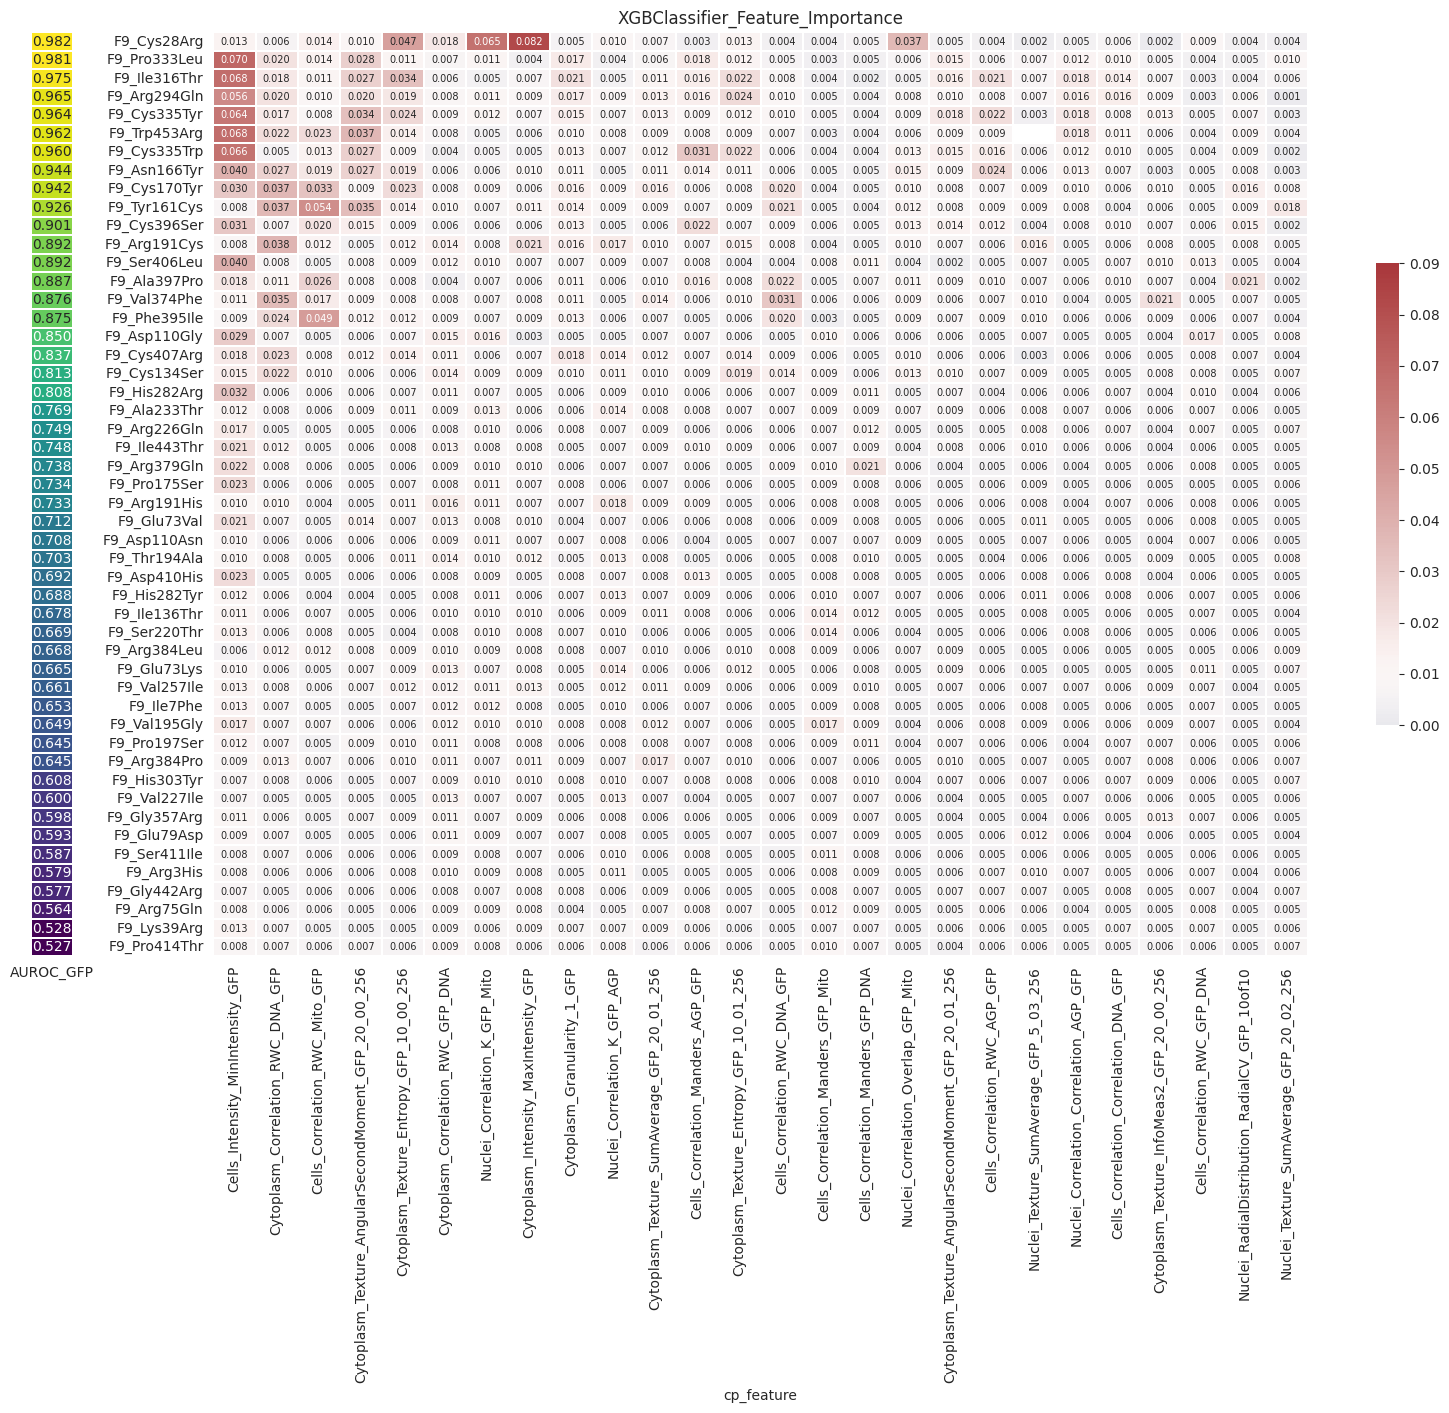

In [120]:
sorted_unique_variants = imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_allele").sort(
    "AUROC_Mean_GFP", descending=True
)["gene_allele"].to_list()
print(len(sorted_unique_variants))

## grep the top features to look at
# get_top_feats = feat_df[["cp_feature"]+[idx for idx in feat_df.columns if gene in idx]].with_columns(
#     pl.mean_horizontal(
#         pl.col(sorted_unique_variants)
#     ).alias('row_mean')
# ).sort(sorted_unique_variants, descending=True)["cp_feature"].to_list()[-10:][::-1]

## get the features with max_feat_importance > 0.015 in any GENE variant
get_top_feats = feat_df.with_columns(
    pl.mean_horizontal(
        pl.col(sorted_unique_variants)
    ).alias('row_mean')
).select(
    ["cp_feature","row_mean"]+[idx for idx in feat_df.columns if gene in idx]
).filter(
   pl.max_horizontal(sorted_unique_variants) > .015 #0.015
).sort("row_mean", descending=True)["cp_feature"].to_list()

your_score_array = imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_allele").sort(
    "AUROC_Mean_GFP", descending=True
)["AUROC_Mean_GFP"].to_numpy()

plt.clf()
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(1, 2, width_ratios=[0.03, 1], wspace=.2)

# Left side: score bar
ax_left = fig.add_subplot(gs[:, 0])
score_data = your_score_array.reshape(-1, 1)
sns.heatmap(score_data, ax=ax_left, annot=True, cbar=False, cmap="viridis", 
            yticklabels=False, xticklabels=['AUROC_GFP'], fmt='.3f', linewidth=.1)

# Main heatmap
ax_main = fig.add_subplot(gs[:, 1])
sns.heatmap(
  data=feat_df.to_pandas().set_index("cp_feature").loc[get_top_feats,sorted_unique_variants].T,
  ax=ax_main,
  cmap="vlag",
    center=0.01, vmin=0, vmax=0.09,
  cbar_kws={"shrink": 0.5},
    yticklabels=1,
    xticklabels=1, linewidth=.1,
    annot=True, fmt='.3f',annot_kws={"fontsize":7},
)
ax_main.set_ylabel('')
ax_main.set_title("XGBClassifier_Feature_Importance")
plt.show()

In [122]:
ref_var_cell_all_prof_df = sc_profile_feat_orig_b1314
norm_vars_feat_df, norm_var_sc_feat_df = pl.DataFrame(), pl.DataFrame()
sig_diff_feat = [feat for feat in get_top_feats if feat in ref_var_cell_all_prof_df.columns]

for gene in tqdm(["F9"]):
    gene_mean = ref_var_cell_all_prof_df.filter(pl.col("Metadata_gene_allele")==gene).select(sig_diff_feat).mean().to_numpy()[0].tolist()
    gene_std = ref_var_cell_all_prof_df.filter(pl.col("Metadata_gene_allele")==gene).select(sig_diff_feat).std().to_numpy()[0].tolist()
    
    z_norm_var_sc_feat_df = ref_var_cell_all_prof_df.filter(
        (pl.col("Metadata_gene_allele").str.starts_with(f"{gene}_"))
        &(pl.col("Metadata_gene_allele")!=gene)
        &(pl.col("Metadata_gene_allele").is_in(imaging_summary_clinvar["gene_allele"].unique()))
    ).with_columns(
        [((pl.col(col) - pl.lit(gene_mean[i])) / pl.lit(gene_std[i])).alias(col)
        for i, col in enumerate(sig_diff_feat)]
    )
    
    norm_var_sc_feat_df = pl.concat([
        norm_var_sc_feat_df,
        z_norm_var_sc_feat_df
    ])
    
    z_norm_var_feat_df = z_norm_var_sc_feat_df.group_by(
        "Metadata_gene_allele", "Metadata_Plate", "Metadata_Well" ## aggregate by well first
    ).agg(
        pl.col(col).mean().alias(col)
        for col in sig_diff_feat
    ).group_by(
        "Metadata_gene_allele" ## aggregate by allele
    ).agg(
        pl.col(col).median().alias(col)
        for col in sig_diff_feat
    )#.to_pandas().set_index("Metadata_gene_allele")[sig_diff_feat]
    
    norm_vars_feat_df = pl.concat([norm_vars_feat_df, 
                                   z_norm_var_feat_df], 
                                  how="diagonal")

100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


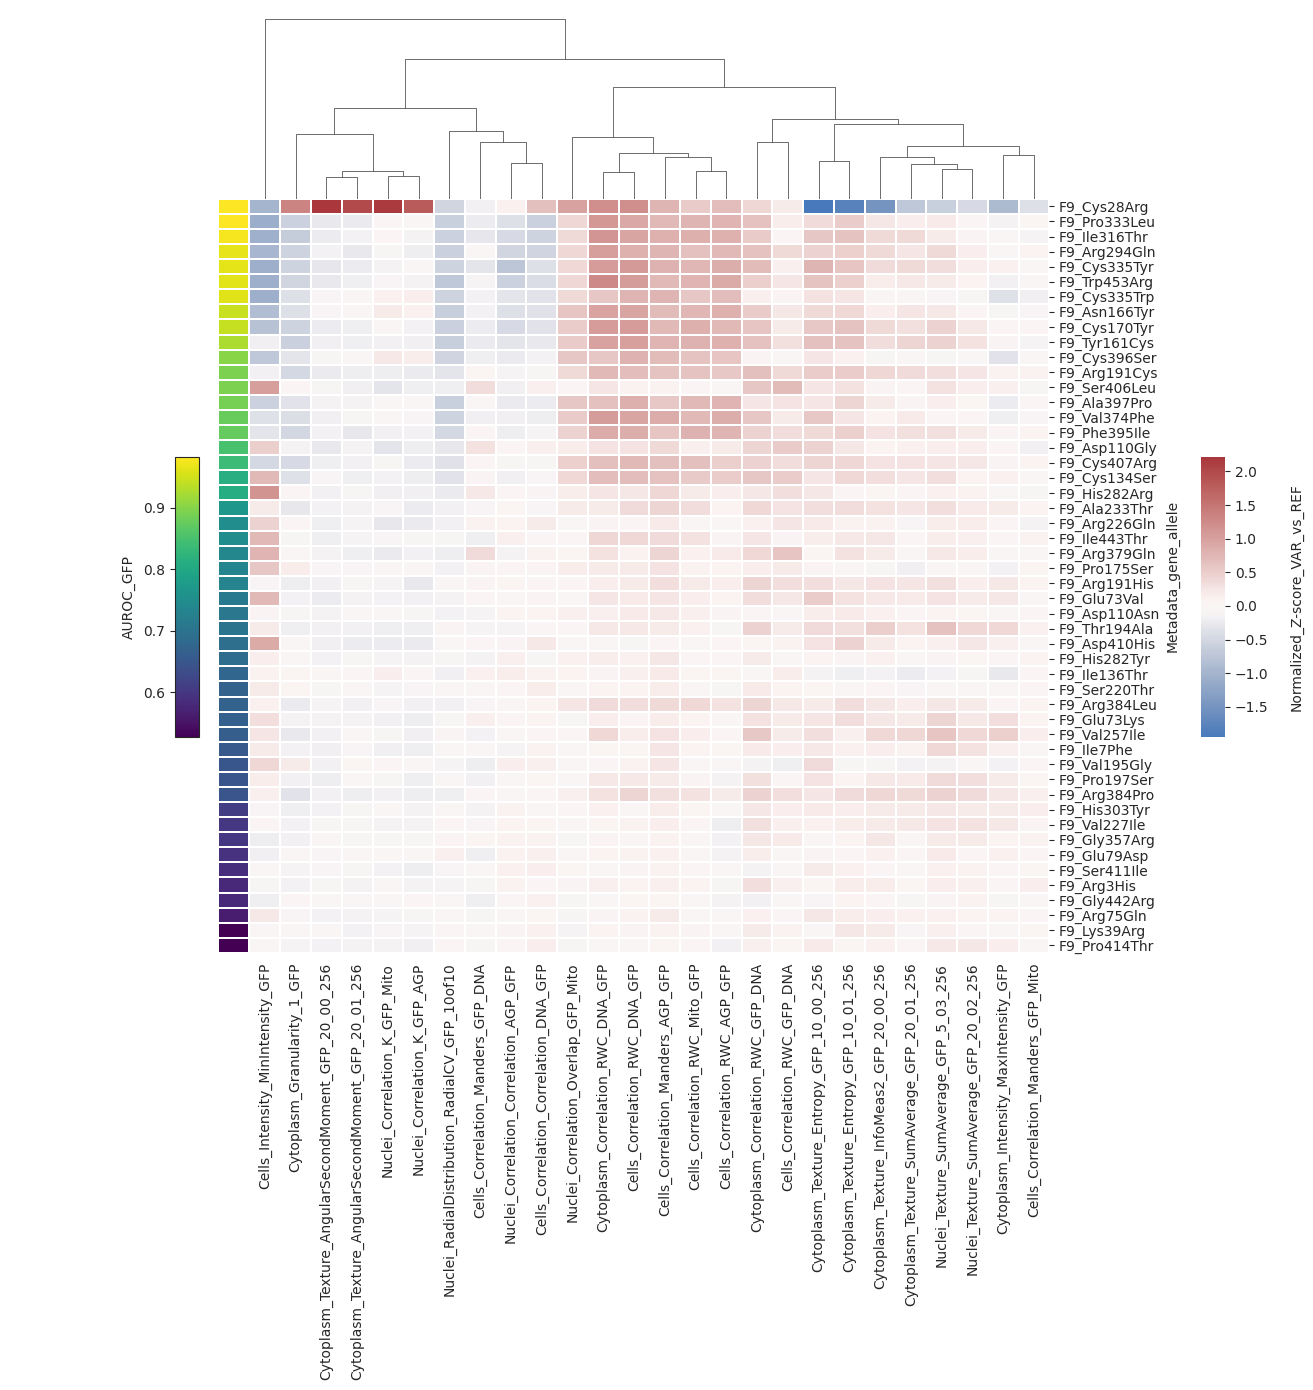

In [123]:
from matplotlib.colors import Normalize

# df_with_scores = pd.DataFrame(your_score_array, index=sorted_unique_variants, columns=['AUROC_GFP'])
# Create a pandas Series with proper index
row_colors_series = pd.Series(your_score_array, index=sorted_unique_variants, name='AUROC_GFP')

# Map to colors
norm = Normalize(vmin=row_colors_series.min(), vmax=row_colors_series.max())
cmap = plt.cm.viridis
row_colors = cmap(norm(row_colors_series.values))

# Create clustermap with custom colorbar positions
g = sns.clustermap(
   data=norm_vars_feat_df.to_pandas().set_index("Metadata_gene_allele").loc[sorted_unique_variants,[c for c in get_top_feats if c in norm_vars_feat_df.columns]],
   cmap="vlag", center=0,
   row_colors=row_colors,
    row_cluster=False,
   cbar_pos=(1.005, 0.47, 0.02, 0.2),  # (left, bottom, width, height) - smaller, center right,
    yticklabels=1, xticklabels=1,
    figsize=(12,14),
    linewidth=.1,
)

# Add label to main heatmap colorbar
g.cax.set_ylabel('Normalized_Z-score_VAR_vs_REF', rotation=90, labelpad=15)

# Add colorbar for row colors on center left
row_cbar_ax = g.fig.add_axes([.15, 0.47, 0.02, 0.2])  # smaller, center left
row_cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                      cax=row_cbar_ax)
row_cbar.set_label('AUROC_GFP', rotation=90, labelpad=5)
row_cbar.ax.yaxis.set_label_position('left')
row_cbar.ax.yaxis.tick_left()
plt.show()

<ipython-input-145-8bfb2501db2b>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)


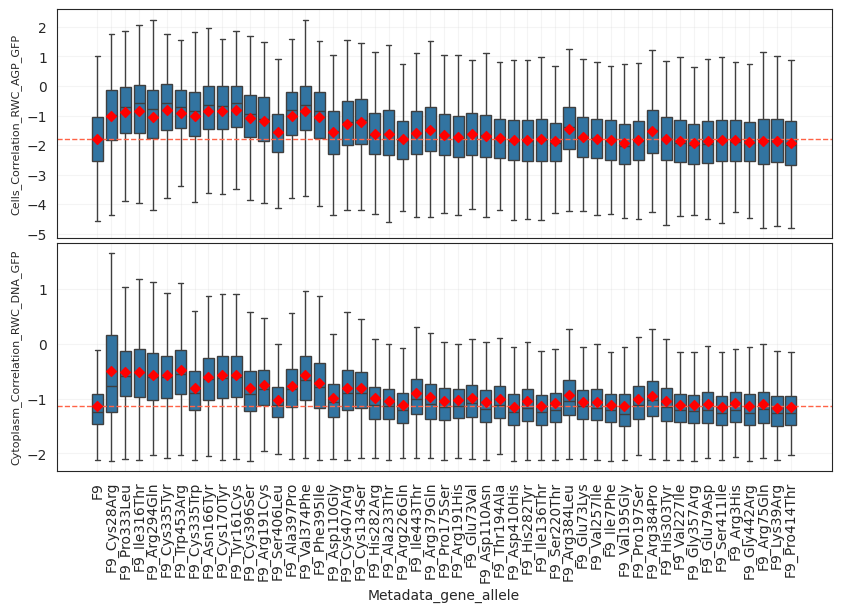

In [145]:
feats = ["Cells_Correlation_RWC_AGP_GFP", "Cytoplasm_Correlation_RWC_DNA_GFP"]
ref_var_allele = ["F9"]+sorted_unique_variants
data_for_plot = ref_var_cell_all_prof_df.filter(
   pl.col("Metadata_gene_allele").is_in(ref_var_allele)
).to_pandas()

fig, axes = plt.subplots(2,1,figsize=(10,6),sharex=True)

sns.boxplot(
    data=data_for_plot,
    x="Metadata_gene_allele",
    y=feats[0],
    showfliers=False,
    order=ref_var_allele,
    ax=axes[0]
    # hue="Metadata_gene_allele",
    # hue_order=sorted(sc_profile_feat_orig.filter(
    #     pl.col("Metadata_gene_allele").str.contains("BAP1")
    # )["Metadata_gene_allele"].unique())
)
sns.boxplot(
    data=data_for_plot,
    x="Metadata_gene_allele",
    y=feats[1],
    showfliers=False,
    order=ref_var_allele,
    ax=axes[1]
    # hue="Metadata_gene_allele",
    # hue_order=sorted(sc_profile_feat_orig.filter(
    #     pl.col("Metadata_gene_allele").str.contains("BAP1")
    # )["Metadata_gene_allele"].unique())
)

for i, feat in enumerate(feats):
    # Add mean points
    means = data_for_plot.groupby("Metadata_gene_allele")[feat].mean()
    for j, allele in enumerate(ref_var_allele):
       axes[i].scatter(j, means[allele], color='red', s=25, marker='D', zorder=10)
    axes[i].axhline(means["F9"], linewidth=1, color="tomato", linestyle="--")
    axes[i].grid(alpha=.2)
    axes[i].set_ylabel(feat, fontsize=8)
        
# ax.set_yscale("log")
axes[1].set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=10)
plt.subplots_adjust(hspace=.02)
plt.show()

In [126]:
norm_vars_feat_meta_df = norm_vars_feat_df.join(
    imaging_summary_clinvar_pillar_snp_match_df_gene.unique("gene_allele"),
    left_on="Metadata_gene_allele",
    right_on="gene_allele"
).rename(
    dict(
        zip(
            [c for c in imaging_summary_clinvar_pillar_snp_match_df_gene.columns if c not in norm_vars_feat_df.columns and c != "gene_allele"],
            [f"Metadata_{c}" for c in imaging_summary_clinvar_pillar_snp_match_df_gene.columns if c not in norm_vars_feat_df.columns and c != "gene_allele"]
        )
    )
)

In [127]:
from sklearn.decomposition import PCA
from functools import reduce
from pycytominer.feature_select import feature_select
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances
import networkx as nx
import community.community_louvain as community_louvain
import umap

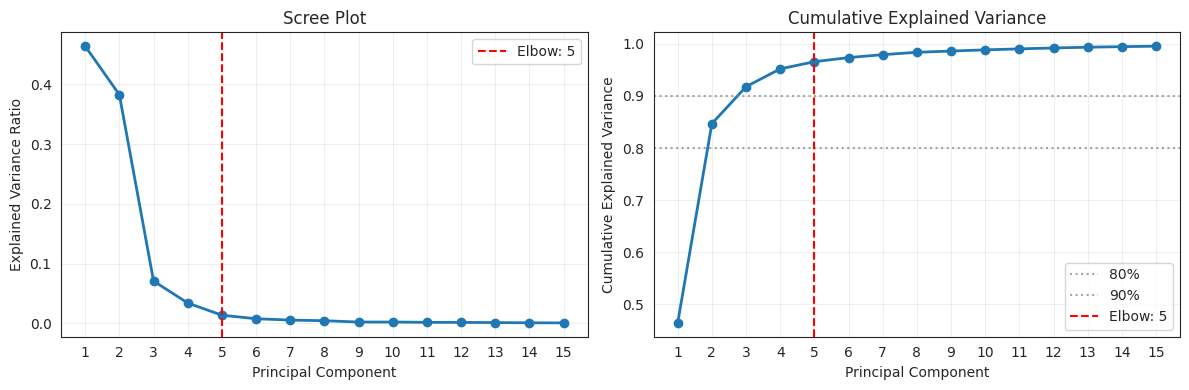

Optimal components: 5
Explained variance at elbow: 96.6%


In [128]:
# Fit PCA with all components
feature_cols = [c for c in norm_vars_feat_meta_df.columns if "Metadata" not in c]

pca_full = PCA()
pca_full.fit(norm_vars_feat_meta_df.select(feature_cols).to_numpy())

# Calculate variances
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

from kneed import KneeLocator
# Find elbow point using KneeLocator
knee_locator = KneeLocator(
    range(1, len(explained_variance_ratio)+1),
    explained_variance_ratio,
    curve='convex',
    direction='decreasing'
)
optimal_components = knee_locator.knee

# explained_var_thres = 0.6
# cumvar = np.cumsum(pca_full.explained_variance_ratio_)
# optimal_components = np.argmax(cumvar >= explained_var_thres) + 1

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Scree plot
n_show = min(15, len(explained_variance_ratio))
ax1.plot(range(1, n_show + 1), explained_variance_ratio[:n_show], 'o-', linewidth=2)
ax1.axvline(x=optimal_components, color='red', linestyle='--', label=f'Elbow: {optimal_components}')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Scree Plot')
ax1.set_xticks(range(1, n_show + 1))
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative variance plot
ax2.plot(range(1, n_show + 1), cumulative_variance[:n_show], 'o-', linewidth=2)
ax2.axhline(y=0.8, color='gray', linestyle=':', alpha=0.7, label='80%')
ax2.axhline(y=0.9, color='gray', linestyle=':', alpha=0.7, label='90%')
ax2.axvline(x=optimal_components, color='red', linestyle='--', label=f'Elbow: {optimal_components}')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.set_title('Cumulative Explained Variance')
ax2.set_xticks(range(1, n_show + 1))
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Results
print(f"Optimal components: {optimal_components}")
print(f"Explained variance at elbow: {cumulative_variance[optimal_components-1]:.1%}")

# Apply optimal PCA
pca = PCA(n_components=optimal_components)
data_pca = pca.fit_transform(norm_vars_feat_meta_df.select(feature_cols).to_numpy())

In [129]:
# UMAP plot
reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=1) ## metric='cosine', 
umap_embedding = reducer.fit_transform(data_pca)

In [130]:
# Generate k-NN graph
k = 10  # adjust based on testing
nbrs = NearestNeighbors(n_neighbors=k, metric='cosine')
nbrs.fit(data_pca)
distances, indices = nbrs.kneighbors(data_pca)

# Build unweighted graph
G = nx.Graph()
for i in range(len(data_pca)):
    for j in indices[i][1:]:  # skip self
        G.add_edge(i, j)

# Louvain clustering
cluster_dict = community_louvain.best_partition(G) # , resolution=2

In [131]:
dr_res_df = pd.DataFrame(
    data_pca,
    columns=[f"PC{i}" for i in range(1, data_pca.shape[1]+1)]
)
dr_res_df = pd.concat([
    dr_res_df,
    pd.DataFrame(umap_embedding, 
                 columns=["UMAP1", "UMAP2"])
    ],
    axis=1
)
dr_res_df["cluster"] = dr_res_df.index.map(cluster_dict)
dr_res_df["Metadata_AUROC_Mean_GFP"] = norm_vars_feat_meta_df["Metadata_AUROC_Mean_GFP"]
dr_res_df["Metadata_Altered_95th_perc_both_batches_GFP"] = norm_vars_feat_meta_df["Metadata_Altered_95th_perc_both_batches_GFP"]
dr_res_df.index = norm_vars_feat_meta_df["Metadata_gene_allele"]

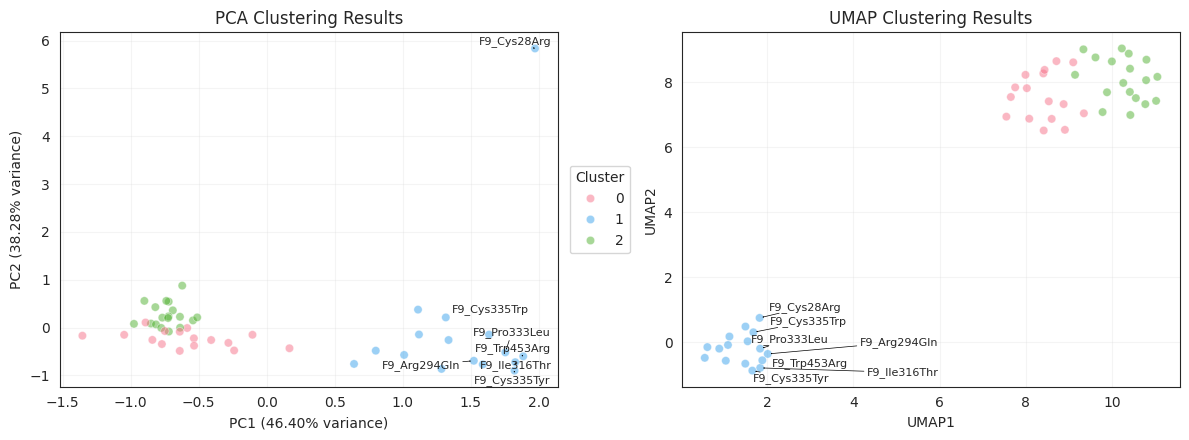

In [132]:
# Get unique clusters and create color palette
n_clusters = len(np.unique(dr_res_df["cluster"]))
colors = sns.color_palette("husl", n_clusters)
color_map = {cluster: colors[i] for i, cluster in enumerate(dr_res_df["cluster"].unique())}
auroc_thres = 0.95

fig, ax = plt.subplots(1,2, figsize=(12, 4.5))
# PCA plot
sns.scatterplot(
    dr_res_df,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette=color_map,
    ax=ax[0],
    alpha=.5,
    # legend=False
)
# for cluster in unique_clusters:
#     mask = np.array(clusters) == cluster
#     ax[0].scatter(data_pca[mask, 0], data_pca[mask, 1], 
#                  c=[color_map[cluster]], label=f'Cluster {cluster}',
#                  s=40, alpha=0.5)
ax[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax[0].set_title('PCA Clustering Results')
ax[0].legend(bbox_to_anchor=(1.01, 0.5), loc='center left', title="Cluster", ncol=1)

# PCA plot
sns.scatterplot(
    dr_res_df,
    x="UMAP1",
    y="UMAP2",
    hue="cluster",
    palette=color_map,
    ax=ax[1],
    alpha=.5,
    legend=False
)
# Add text labels for high-scoring points in PCA
high_score_mask = dr_res_df['Metadata_AUROC_Mean_GFP'] >= auroc_thres
# ax[1].get_legend().remove()

texts_pca = []
for idx in dr_res_df[high_score_mask].index:
   texts_pca.append(ax[0].text(
       dr_res_df.loc[idx, 'PC1'],
       dr_res_df.loc[idx, 'PC2'],
       str(idx),
       fontsize=8
   ))
adjust_text(texts_pca, ax=ax[0], arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Add text labels for high-scoring points in UMAP
texts_umap = []
for idx in dr_res_df[high_score_mask].index:
   texts_umap.append(ax[1].text(
       dr_res_df.loc[idx, 'UMAP1'],
       dr_res_df.loc[idx, 'UMAP2'],
       str(idx),
       fontsize=8
   ))
adjust_text(texts_umap, ax=ax[1], arrowprops=dict(arrowstyle='->', color='black', lw=0.5))


# for cluster in unique_clusters:
#     mask = np.array(clusters) == cluster
#     ax[1].scatter(embedding[mask, 0], embedding[mask, 1],
#                  c=[color_map[cluster]], label=f'Cluster {cluster}',
#                  s=40, alpha=0.5)

ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('UMAP Clustering Results')

ax[0].grid(alpha=.2)
ax[1].grid(alpha=.2)
plt.subplots_adjust(wspace=.3)
plt.tight_layout()
plt.show()

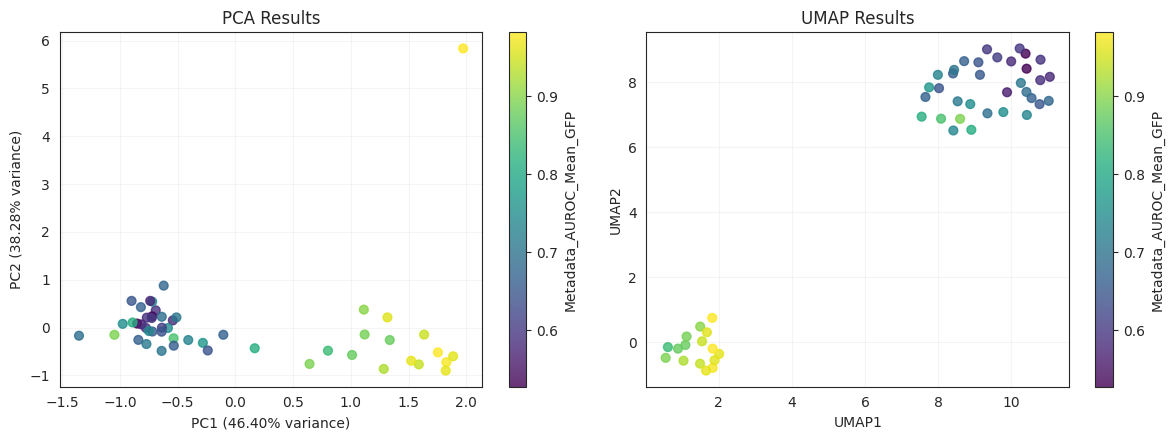

In [133]:
# Assuming your continuous score column is named 'score' in dr_res_df
# If it has a different name, replace 'score' with your column name

from matplotlib.colors import Normalize
import matplotlib.pyplot as plt

# Create normalization and colormap for continuous scores
norm = Normalize(vmin=dr_res_df['Metadata_AUROC_Mean_GFP'].min(), vmax=dr_res_df['Metadata_AUROC_Mean_GFP'].max())
cmap = plt.cm.viridis

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

# PCA plot with continuous coloring
scatter1 = ax[0].scatter(
    dr_res_df['PC1'],
    dr_res_df['PC2'],
    c=dr_res_df['Metadata_AUROC_Mean_GFP'],
    cmap=cmap,
    alpha=0.8,
    s=40
)
ax[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax[0].set_title('PCA Results')
plt.colorbar(scatter1, ax=ax[0], label='Metadata_AUROC_Mean_GFP')

# UMAP plot with continuous coloring
scatter2 = ax[1].scatter(
    dr_res_df['UMAP1'],
    dr_res_df['UMAP2'],
    c=dr_res_df['Metadata_AUROC_Mean_GFP'],
    cmap=cmap,
    alpha=0.8,
    s=40,
)
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('UMAP Results')
plt.colorbar(scatter2, ax=ax[1], label='Metadata_AUROC_Mean_GFP')

ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)
plt.tight_layout()
plt.show()

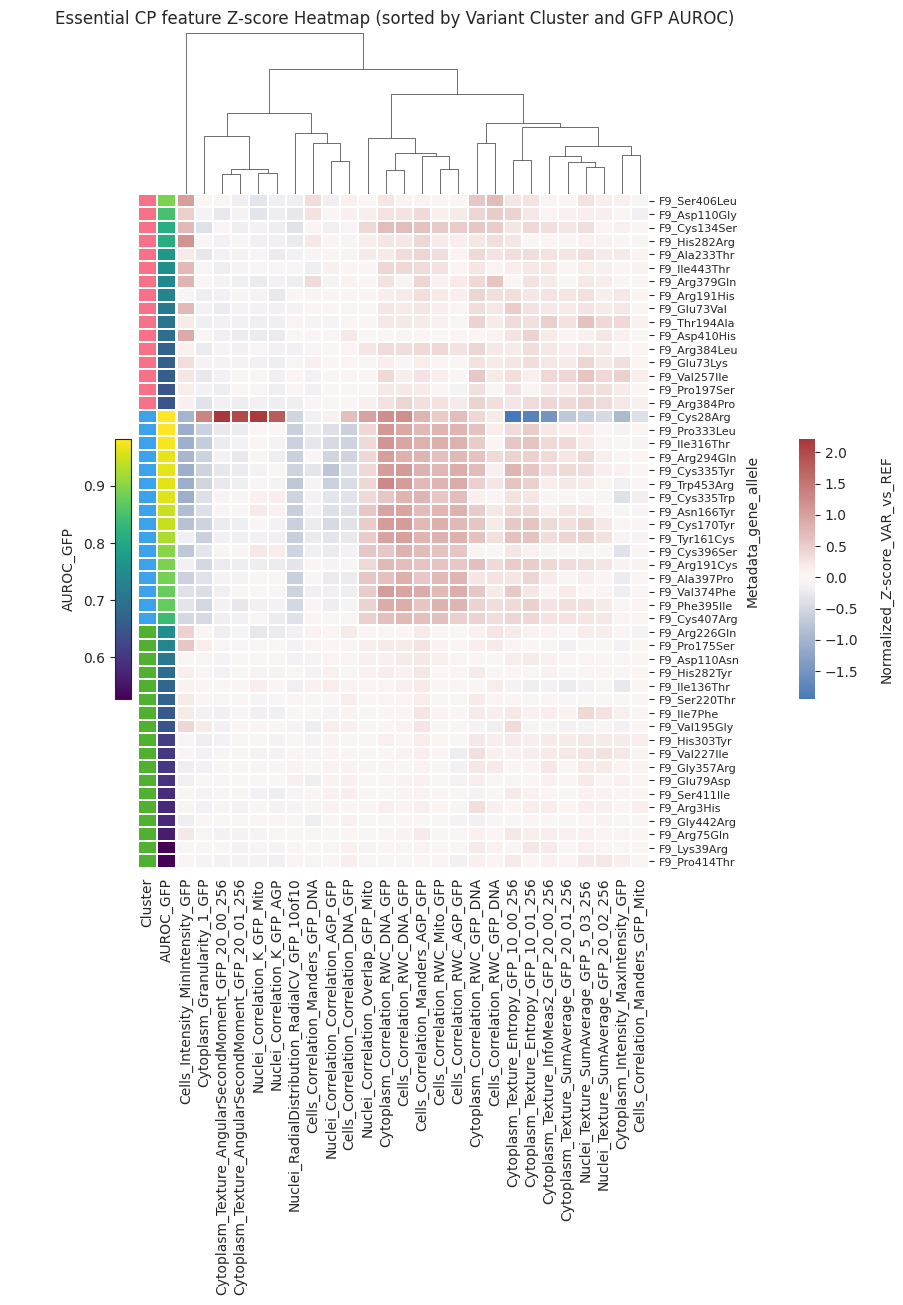

In [134]:
# Get cluster order from UMAP clustering
cluster_order = dr_res_df.sort_values('cluster')['cluster'].unique()

# Create cluster color mapping
n_clusters = len(np.unique(dr_res_df["cluster"]))
cluster_colors = sns.color_palette("husl", n_clusters)
cluster_color_map = {cluster: cluster_colors[i] for i, cluster in enumerate(dr_res_df["cluster"].unique())}

# Create ordered list based on clusters, then by score within clusters
ordered_variants = []
cluster_labels = []
for cluster in cluster_order:
   cluster_variants = dr_res_df[dr_res_df['cluster'] == cluster].sort_values('Metadata_AUROC_Mean_GFP', ascending=False).index.tolist()
   ordered_variants.extend(cluster_variants)
   cluster_labels.extend([cluster] * len(cluster_variants))

# Filter to only variants present in both datasets
available_variants = []
available_cluster_labels = []
for i, variant in enumerate(ordered_variants):
   if variant in sorted_unique_variants:
       available_variants.append(variant)
       available_cluster_labels.append(cluster_labels[i])

# Get scores for the ordered variants
ordered_scores = []
for variant in available_variants:
   score = norm_vars_feat_meta_df.filter(pl.col("Metadata_gene_allele") == variant)["Metadata_AUROC_Mean_GFP"].item()
   ordered_scores.append(score)

ordered_scores_array = np.array(ordered_scores)

# Create row colors - AUROC scores
auroc_colors_series = pd.Series(ordered_scores_array, index=available_variants, name='AUROC_GFP')
norm = Normalize(vmin=auroc_colors_series.min(), vmax=auroc_colors_series.max())
cmap = plt.cm.viridis
auroc_colors = cmap(norm(auroc_colors_series.values))

# Create cluster colors array - convert RGBA tuples to arrays
cluster_colors_array = np.array([cluster_color_map[cluster] for cluster in available_cluster_labels])

# Combine both color arrays as separate columns
row_colors_df = pd.DataFrame(index=available_variants)
row_colors_df['Cluster'] = [cluster_color_map[cluster] for cluster in available_cluster_labels]
row_colors_df['AUROC_GFP'] = list(auroc_colors)

# Create clustermap with cluster-based ordering
g = sns.clustermap(
   data=norm_vars_feat_meta_df.to_pandas().set_index("Metadata_gene_allele").loc[available_variants, [c for c in get_top_feats if c in norm_vars_feat_meta_df.columns]],
   cmap="vlag", center=0,
   row_colors=row_colors_df,
   row_cluster=False,
   cbar_pos=(1.005, 0.47, 0.02, 0.2),
   yticklabels=1, xticklabels=1,
   figsize=(8, 13),
    linewidth=.1
)
g.fig.suptitle("Essential CP feature Z-score Heatmap (sorted by Variant Cluster and GFP AUROC)", fontsize=12, y=1.)
# Add label to main heatmap colorbar
g.cax.set_ylabel('Normalized_Z-score_VAR_vs_REF', rotation=90, labelpad=15)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=8) # Adjust fontsize as needed

# Add colorbar for AUROC scores
auroc_cbar_ax = g.fig.add_axes([.15, 0.47, 0.02, 0.2])
auroc_cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=auroc_cbar_ax)
auroc_cbar.set_label('AUROC_GFP', rotation=90, labelpad=5)
auroc_cbar.ax.yaxis.set_label_position('left')
auroc_cbar.ax.yaxis.tick_left()

plt.show()